# 패스트캠퍼스 검색광고 데이터 분석
<br>

![nn](캡처1.JPG)

## 데이터의 구성 : 
![nn](캡처2.JPG)

| 광고성과지표 | = | 계산식 |
|:---------- |---------- |:---------- |
|CTR(Click Through Rate)|=|클릭수 / 노출수 * 100|
|CPM(Cost Per Mile)|=|광고비용 / 노출수 * 1000|
|CPC(Cost Per Click)|=|광고비용 / 클릭수|
|CPA(Cost Per Action)|=|광고비용 / 구매수|

## 분석목표 : 
1. 중점관리 키워드, 저효율 키워드 추출
2. 중점관리 광고그룹, 저효율 광고그룹 추출


### 1. 데이터 전처리

- read_excel함수를 사용하여 파이썬에 데이터 불러오기 
- 데이터프레임의 열 단위 수치연산 및 데이터 타입 다루기

In [8]:
import matplotlib.pyplot as plt
import pandas as pd
import set_matplotlib_hangul

In [49]:
df=pd.read_excel('네이버보고서.xls',skiprows=[0])
df.head()

,광고그룹,키워드,노출수,클릭수,클릭률(%),"평균클릭비용(VAT포함,원)","총비용(VAT포함,원)"
0,올인원 패키지 : 디자인 툴_파워컨텐츠_포토샵,-,2319456,9606.0,0.414149,261.549448,2512444
1,올인원 패키지 : 업무자동화_VBA,-,767491,8058.0,1.049915,295.974808,2384965
2,ㅍAOP 전체_중복키워드_디자인(삭제),일러스트,1137840,324.0,0.028475,4841.663580,1568699
3,올인원 패키지 : 데이터 분석 입문 온라인_파콘,-,694106,1863.6,0.268489,630.593475,1175174
4,3. html,HTML,9626374,813.6,0.008452,1408.435349,1145903


In [32]:
df.shape

(1381, 7)

In [33]:
df.describe()

,노출수,클릭수,클릭률(%),"평균클릭비용(VAT포함,원)","총비용(VAT포함,원)"
count,1.381000e+03,1381.000000,1381.000000,1381.000000,1.381000e+03
mean,3.505415e+04,52.504707,0.352023,981.624909,3.791958e+04
std,2.964650e+05,387.513479,1.000998,1372.401050,1.421492e+05
min,1.001000e+03,0.000000,0.000000,0.000000,0.000000e+00
25%,1.814000e+03,1.000000,0.006539,64.000000,7.700000e+01
50%,3.805000e+03,4.000000,0.056721,396.000000,2.123000e+03
75%,1.073400e+04,14.000000,0.243309,1303.000000,1.743500e+04
max,9.626374e+06,9606.000000,13.590551,9363.000000,2.512444e+06


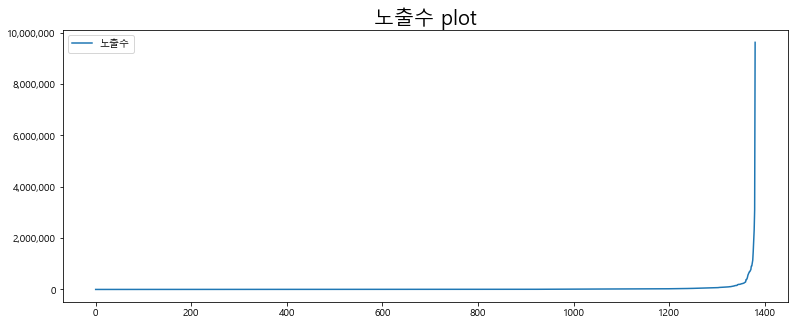

In [6]:
((((df['노출수'].sort_values())/1000).reset_index()).drop('index',axis=1)).plot(figsize=[13,5])
plt.yticks([0,2000,4000,6000,8000,10000],[0,'2,000,000','4,000,000','6,000,000','8,000,000','10,000,000'])
plt.title('노출수 plot',fontsize=20)
plt.show()

- 결측치 확인

In [9]:
df.isnull().sum()

광고그룹               0
키워드                0
노출수                0
클릭수                0
클릭률(%)             0
평균클릭비용(VAT포함,원)    0
총비용(VAT포함,원)       0
dtype: int64

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1381 entries, 0 to 1380
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   광고그룹             1381 non-null   object 
 1   키워드              1381 non-null   object 
 2   노출수              1381 non-null   int64  
 3   클릭수              1381 non-null   float64
 4   클릭률(%)           1381 non-null   float64
 5   평균클릭비용(VAT포함,원)  1381 non-null   float64
 6   총비용(VAT포함,원)     1381 non-null   int64  
dtypes: float64(3), int64(2), object(2)
memory usage: 75.6+ KB


## 데이터 분석

### 중점관리키워드 추출
- 노출수, 클릭수 기준 상위 5%에 해당하는 키워드 추출 
 1. 95백분위수 찾기(quantile 함수 사용)
 2. 95백분위수 이상(상위 5%)의 노출수 추출
 3. 상위 5%에 해당하는 키워드 추출

In [39]:
#노출수 칼럼 imp변수에 할당
imp=df['노출수']

#### 1. 95백분위수 찾기

In [47]:
#quantile - 분위수 출력(default : 2사분위수(중앙값))
imp.quantile()

197479.0

In [41]:
imp.median()

3805.0

In [44]:
#quantile(0) - 최소값
imp.quantile(0)

1001.0

In [43]:
#quantile(1) - 최대값
imp.quantile(1)

9626374.0

In [42]:
#95백분위수 = quantile(0.95)
imp.quantile(0.95)

82858.0

#### 2. 95백분위수 이상(상위 5%)의 노출수 추출

In [45]:
imp=imp[imp>=imp.quantile(0.95)]

In [46]:
imp

0      2319456
1       767491
2      1137840
3       694106
4      9626374
        ...   
698     196862
741      94933
763      82858
777     126393
780      90041
Name: 노출수, Length: 70, dtype: int64

#### 3. 상위 5%에 해당하는 키워드 추출<br>
      -기존 상위 노출수 추출과정
        1. as-is : 데이터프레임의 기본숫자인덱스 
        2. to-be : 데이터프레임의 인덱스를 '키워드'로 재설정

In [50]:
df.head()

,광고그룹,키워드,노출수,클릭수,클릭률(%),"평균클릭비용(VAT포함,원)","총비용(VAT포함,원)"
0,올인원 패키지 : 디자인 툴_파워컨텐츠_포토샵,-,2319456,9606.0,0.414149,261.549448,2512444
1,올인원 패키지 : 업무자동화_VBA,-,767491,8058.0,1.049915,295.974808,2384965
2,ㅍAOP 전체_중복키워드_디자인(삭제),일러스트,1137840,324.0,0.028475,4841.663580,1568699
3,올인원 패키지 : 데이터 분석 입문 온라인_파콘,-,694106,1863.6,0.268489,630.593475,1175174
4,3. html,HTML,9626374,813.6,0.008452,1408.435349,1145903


In [52]:
df_index=df.set_index('키워드')
df_index

,광고그룹,노출수,클릭수,클릭률(%),"평균클릭비용(VAT포함,원)","총비용(VAT포함,원)"
키워드,,,,,,
-,올인원 패키지 : 디자인 툴_파워컨텐츠_포토샵,2319456,9606.0,0.414149,261.549448,2512444
-,올인원 패키지 : 업무자동화_VBA,767491,8058.0,1.049915,295.974808,2384965
일러스트,ㅍAOP 전체_중복키워드_디자인(삭제),1137840,324.0,0.028475,4841.663580,1568699
-,올인원 패키지 : 데이터 분석 입문 온라인_파콘,694106,1863.6,0.268489,630.593475,1175174
HTML,3. html,9626374,813.6,0.008452,1408.435349,1145903
...,...,...,...,...,...,...
엑셀셀서식,올인원 패키지 : 업무자동화_3. 엑셀,24016,0.0,0.000000,0.000000,0
MATCH,올인원 패키지 : 업무자동화_3. 엑셀,32287,0.0,0.000000,0.000000,0
LTV,마케팅KPI수립,32602,0.0,0.000000,0.000000,0


In [54]:
#df_index에서 quantile(0.95)
#imp 변수 출력, 노출수 상위 5% 키워드 추출
imp=df_index['노출수'][df_index['노출수']>=df_index['노출수'].quantile(0.95)]

In [55]:
imp

키워드
-         2319456
-          767491
일러스트      1137840
-          694106
HTML      9626374
           ...   
부동산스터디     196862
가상메모리       94933
프로모션        82858
앱스토어       126393
OS          90041
Name: 노출수, Length: 70, dtype: int64

In [57]:
#df_index에서 클릭수 상위 5% 키워드 추출
clk=df_index['클릭수'][df_index['클릭수']>=df_index['클릭수'].quantile(0.95)]
clk

키워드
-          9606.0
-          8058.0
일러스트        324.0
-          1863.6
HTML        813.6
            ...  
재태크         126.0
모스자격증       198.0
펀드하는법       248.4
채권투자        135.6
주식투자하는법     120.0
Name: 클릭수, Length: 70, dtype: float64

#### 중점관리키워드 선별
 - 노출수와 클릭수 모두 95백분위수 이상
 
#### 조건이 여러개일  경우 
 - 데이터프레임[(조건문)&(조건문)]

In [59]:
#df_index에서 imp, clk 변수 생성
imp=df_index['노출수']
clk=df_index['클릭수']

In [60]:
#노출수와 클릭수 모두 상위5%(95백분위수 이상) 추출

result=df_index[(imp>=imp.quantile(0.95))&(clk>=clk.quantile(0.95))]
result

,광고그룹,노출수,클릭수,클릭률(%),"평균클릭비용(VAT포함,원)","총비용(VAT포함,원)"
키워드,,,,,,
-,올인원 패키지 : 디자인 툴_파워컨텐츠_포토샵,2319456,9606.0,0.414149,261.549448,2512444
-,올인원 패키지 : 업무자동화_VBA,767491,8058.0,1.049915,295.974808,2384965
일러스트,ㅍAOP 전체_중복키워드_디자인(삭제),1137840,324.0,0.028475,4841.663580,1568699
-,올인원 패키지 : 데이터 분석 입문 온라인_파콘,694106,1863.6,0.268489,630.593475,1175174
HTML,3. html,9626374,813.6,0.008452,1408.435349,1145903
파이썬,6. 파이썬,384522,260.4,0.067720,3705.360983,964876
코딩,1. 코딩,562162,271.2,0.048242,3243.215339,879560
C언어,2. C언어 일반,271370,153.6,0.056602,5269.257812,809358
가상화폐,프로그래밍 전체_파워컨텐츠_블록체인(삭제),91369,2838.0,3.106086,283.217054,803770


In [61]:
result.index

Index(['-', '-', '일러스트', '-', 'HTML', '파이썬', '코딩', 'C언어', '가상화폐', '포토샵',
       '블록체인', '엑셀', '-', '포토샵', '컴퓨터활용능력', '컴퓨터활용능력2급', '컴퓨터활용능력1급', '포토샵',
       '-', '프리미어프로', '폰트', '스케치', '포토샵', '글씨체', '한글폰트', '마블', '바이럴마케팅'],
      dtype='object', name='키워드')

#### # 저효율키워드 선별

In [66]:
#노출수 선그래프
imp_sort=df['노출수'].sort_values()
imp_sort=imp_sort.reset_index()
imp_sort.drop('index',axis=1,inplace=True)
imp_sort

,노출수
0,1001
1,1003
2,1005
3,1006
4,1007
...,...
1376,1470452
1377,1887822
1378,2319456
1379,3095998


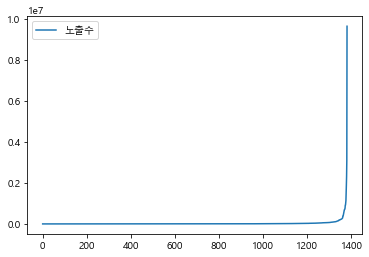

In [68]:
#노출수 선그래프
imp_sort.plot()
plt.show()

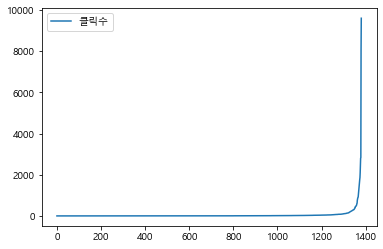

In [69]:
#클릭수 선그래프
(((df['클릭수'].sort_values()).reset_index()).drop('index',axis=1)).plot()
plt.show()

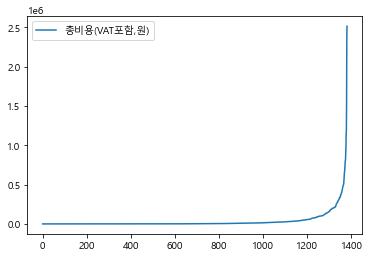

In [71]:
#총비용 선그래프
(((df['총비용(VAT포함,원)'].sort_values()).reset_index()).drop('index',axis=1)).plot()
plt.show()

- 노출수, 클릭수  `기준 상위 5%의 키워드가 아닌데도 불구하고 비용이 많이 쓰이고 있는 키워드
 1. 노출수 95백분위수 미만
 2. 클릭수 95백분위수 미만
 3. 총비용 85백분위수 이상
 4. 총비용 95백분위수 미만
 
 ### # 조건이 여러개일  경우 
 - 데이터프레임[(조건문)&(조건문)]

In [74]:
cost=df_index['총비용(VAT포함,원)']
result=df_index[(imp<imp.quantile(0.95))&(clk<clk.quantile(0.95))&(cost>=cost.quantile(0.85))&(cost<cost.quantile(0.95))]

In [75]:
#index - 저효율키워드 출력
result.index

Index(['온라인마케팅교육', '온라인마케팅', '어플제작비용', '부동산경매', '퍼포먼스마케팅', '블록체인', 'C++',
       '게임만드는프로그램', '엑셀배우기', '앱만들기', '영상제작', '쇼핑몰제작', '에프터이펙트', '어플리케이션제작',
       '강남빌딩매매', '웹디자인', '디지털마케팅', '포토샵강의', '구글애널리틱스자격증', 'PYTHON', '페이스북광고',
       '유튜브마케팅', '게임제작', '부동산투자', '마케팅전략', 'PYTHON', '홈페이지만들기', 'B2B사이트',
       'JAVASCRIPT', '파이썬강좌', '인스타그램광고', '동영상제작', 'SEO', '쇼핑몰창업', '인터넷쇼핑몰',
       '게임프로그래밍학원', '프로그래밍', '서울빌딩매매', '데이터사이언스', '모바일게임제작', '엑셀학원',
       '유튜브크리에이터', '엑셀VBA', '영상편집학원', '텐서플로우', '쇼핑몰홈페이지제작', '엑셀교육', '그로스해킹',
       '게임개발', '광고대행사', '통계학원', '모바일앱개발', '안드로이드앱만들기', '파이썬기초', '하이브리드앱',
       '온라인마케팅', '인디자인', '검색엔진최적화', '엑셀실무', '인터넷쇼핑몰제작', '상가빌딩매매', '퍼포먼스마케팅',
       '쇼핑몰', 'UX디자인', '유니티강좌', 'VBA', '코딩이란', 'SNS마케팅', 'GA자격증', '콘텐츠제작',
       '구글애널리틱스', 'UI디자인', '1인미디어', '포토샵자격증', '하이브리드앱', '포토샵자격증', '브랜드네이밍',
       '리플렛디자인', '데이터사이언티스트', '유니티3D', '자바스크립트', '일러스트레이터강좌', '데이터분석준전문가',
       '유튜브편집', '모션그래픽', '리플렛디자인', 'SPRING', '어도비일러스트레이터', 'SNS광고', '쇼핑몰촬영',
       '브랜드마케팅', '데이터분

#### 광고그룹 분석
- 학습목표 : 
 1. groupby함수 사용실습
 2. 키워드 분석과정에서 진행한 코딩 복습

##### as-is : 키워드  기준 분석
- 키워드의 노출수/클릭수/총비용...

##### to-be : 광고그룹 기준 분석
- 데이터의 구성을 광고그룹 기준으로 변경해야함
- 광고그룹의 노출수/클릭수/총비용...
- groupby 함수 사용

In [78]:
#groupby - 전달된 열을 기준으로 전체 데이터를 분류
grouped=df.groupby('광고그룹')
grouped


In [77]:
grouped.count()

,키워드,노출수,클릭수,클릭률(%),"평균클릭비용(VAT포함,원)","총비용(VAT포함,원)"
광고그룹,,,,,,
#000_마케팅 전체_main,48,48,48,48,48,48
001.BASIC DESIGN,9,9,9,9,9,9
001.데이터분석/ 통계,10,10,10,10,10,10
002.R,9,9,9,9,9,9
002.UX/UI,5,5,5,5,5,5
...,...,...,...,...,...,...
포토샵 유치원_일러스트레이터 유치원,13,13,13,13,13,13
프로그래밍 유치원,8,8,8,8,8,8
프로그래밍 전체,12,12,12,12,12,12


In [79]:
#mean -각 광고그룹 데이터의 평균
grouped.mean()

,노출수,클릭수,클릭률(%),"평균클릭비용(VAT포함,원)","총비용(VAT포함,원)"
광고그룹,,,,,
#000_마케팅 전체_main,14780.145833,8.400000,0.183898,625.086295,7243.958333
001.BASIC DESIGN,5738.555556,6.800000,0.232924,298.693822,2427.333333
001.데이터분석/ 통계,3715.000000,20.280000,0.890571,1021.473357,19575.600000
002.R,13413.777778,8.533333,0.111199,360.038462,4796.000000
002.UX/UI,3090.800000,4.080000,0.089340,69.928571,550.000000
...,...,...,...,...,...
포토샵 유치원_일러스트레이터 유치원,72092.692308,16.707692,0.050832,648.327517,15781.615385
프로그래밍 유치원,5921.625000,7.800000,0.224738,2032.326389,23617.000000
프로그래밍 전체,90375.000000,9.200000,0.024037,123.881559,1626.166667


In [80]:
#median - 그룹 데이터의 중앙값
grouped.median()

,노출수,클릭수,클릭률(%),"평균클릭비용(VAT포함,원)","총비용(VAT포함,원)"
광고그룹,,,,,
#000_마케팅 전체_main,2765.0,3.6,0.055948,765.972222,2458.5
001.BASIC DESIGN,5524.0,2.4,0.038716,357.500000,1023.0
001.데이터분석/ 통계,1813.0,13.8,0.573846,1096.795393,13464.0
002.R,5184.0,3.6,0.028016,119.166667,1287.0
002.UX/UI,2649.0,1.2,0.090600,73.333333,88.0
...,...,...,...,...,...
포토샵 유치원_일러스트레이터 유치원,5763.0,3.6,0.023327,852.500000,2706.0
프로그래밍 유치원,3748.0,3.0,0.121833,1763.819444,8002.5
프로그래밍 전체,3455.5,1.2,0.009331,130.497685,225.5


In [81]:
#std - 그룹 데이터의 표준편차
grouped.std()

,노출수,클릭수,클릭률(%),"평균클릭비용(VAT포함,원)","총비용(VAT포함,원)"
광고그룹,,,,,
#000_마케팅 전체_main,43495.109992,17.731616,0.314900,472.866258,15854.712974
001.BASIC DESIGN,4182.624120,9.138928,0.471768,176.145753,3220.042158
001.데이터분석/ 통계,4109.836709,18.316768,0.817334,269.588218,19127.395160
002.R,19333.628900,14.714619,0.165559,371.704042,10077.594033
002.UX/UI,1996.647866,7.179972,0.105666,69.105148,1005.282050
...,...,...,...,...,...
포토샵 유치원_일러스트레이터 유치원,188247.583461,35.267418,0.060497,470.848706,37543.642006
프로그래밍 유치원,6642.341496,9.769925,0.251239,1649.704939,37088.923190
프로그래밍 전체,200385.152836,17.263730,0.034516,119.977104,2801.701328


In [82]:
#var - 그룹 데이터의 분산
grouped.var()

,노출수,클릭수,클릭률(%),"평균클릭비용(VAT포함,원)","총비용(VAT포함,원)"
광고그룹,,,,,
#000_마케팅 전체_main,1.891825e+09,314.410213,0.099162,2.236025e+05,2.513719e+08
001.BASIC DESIGN,1.749434e+07,83.520000,0.222565,3.102733e+04,1.036867e+07
001.데이터분석/ 통계,1.689076e+07,335.504000,0.668035,7.267781e+04,3.658572e+08
002.R,3.737892e+08,216.520000,0.027410,1.381639e+05,1.015579e+08
002.UX/UI,3.986603e+06,51.552000,0.011165,4.775522e+03,1.010592e+06
...,...,...,...,...,...
포토샵 유치원_일러스트레이터 유치원,3.543715e+10,1243.790769,0.003660,2.216985e+05,1.409525e+09
프로그래밍 유치원,4.412070e+07,95.451429,0.063121,2.721526e+06,1.375588e+09
프로그래밍 전체,4.015421e+10,298.036364,0.001191,1.439451e+04,7.849530e+06


#### 광고그룹 기준 데이터 전처리

In [83]:
#그룹데이터의 합계(sum) - 노출수,클릭수,총비용 칼럼
grouped.sum()

,노출수,클릭수,클릭률(%),"평균클릭비용(VAT포함,원)","총비용(VAT포함,원)"
광고그룹,,,,,
#000_마케팅 전체_main,709447,403.2,8.827081,30004.142165,347710
001.BASIC DESIGN,51647,61.2,2.096316,2688.244398,21846
001.데이터분석/ 통계,37150,202.8,8.905710,10214.733573,195756
002.R,120724,76.8,1.000794,3240.346154,43164
002.UX/UI,15454,20.4,0.446702,349.642857,2750
...,...,...,...,...,...
포토샵 유치원_일러스트레이터 유치원,937205,217.2,0.660812,8428.257716,205161
프로그래밍 유치원,47373,62.4,1.797903,16258.611111,188936
프로그래밍 전체,1084500,110.4,0.288445,1486.578704,19514


- 클릭률, 평균클릭비용 칼럼 전처리 
- as-is : 키워드에 대한 클릭률의 총합(sum), 키워드에 대한 평균클릭비용의 총합(sum)
- to-be : 광고그룹에 대한 클릭률, 광고그룹에 대한 평균클릭비용

In [84]:
#df_group 변수 출력
df_group=grouped.sum()
df_group


,노출수,클릭수,클릭률(%),"평균클릭비용(VAT포함,원)","총비용(VAT포함,원)"
광고그룹,,,,,
#000_마케팅 전체_main,709447,403.2,8.827081,30004.142165,347710
001.BASIC DESIGN,51647,61.2,2.096316,2688.244398,21846
001.데이터분석/ 통계,37150,202.8,8.905710,10214.733573,195756
002.R,120724,76.8,1.000794,3240.346154,43164
002.UX/UI,15454,20.4,0.446702,349.642857,2750
...,...,...,...,...,...
포토샵 유치원_일러스트레이터 유치원,937205,217.2,0.660812,8428.257716,205161
프로그래밍 유치원,47373,62.4,1.797903,16258.611111,188936
프로그래밍 전체,1084500,110.4,0.288445,1486.578704,19514


In [85]:
#클릭률(ctr) = 클릭수 / 노출수
df_group['클릭률(%)']=df_group['클릭수']/df_group['노출수']

In [86]:
#평균클릭비용(cpc) = 총비용 / 클릭수
df_group['평균클릭비용(VAT포함,원)']=df_group['총비용(VAT포함,원)']/df_group['클릭수']

In [87]:
#클릭수 칼럼 중 0인 데이터가 존재 => 평균클릭비용 칼럼 중 결측값이 존재
df_group[df_group['클릭수']==0]

,노출수,클릭수,클릭률(%),"평균클릭비용(VAT포함,원)","총비용(VAT포함,원)"
광고그룹,,,,,
Hyperledger Fabric 프로젝트 CAMP,1990,0.0,0.0,NaN,0
fin_camp_business_4,2136,0.0,0.0,NaN,0
fin_camp_rfs_9,1928,0.0,0.0,NaN,0
다함께 DDD 프로젝트,3689,0.0,0.0,NaN,0
올인원 패키지 : 디지털 마케팅_인스타광고,1377,0.0,0.0,NaN,0


In [88]:
df_group['평균클릭비용(VAT포함,원)']=df_group['평균클릭비용(VAT포함,원)'].fillna(0)

In [89]:
# 평균클릭비용 칼럼 반올림처리(round), 소수점 제거(astype(int)
df_group['평균클릭비용(VAT포함,원)']=round(df_group['평균클릭비용(VAT포함,원)'],0)
df_group['평균클릭비용(VAT포함,원)']=df_group['평균클릭비용(VAT포함,원)'].astype(int)

df_group.head()

,노출수,클릭수,클릭률(%),"평균클릭비용(VAT포함,원)","총비용(VAT포함,원)"
광고그룹,,,,,
#000_마케팅 전체_main,709447,403.2,0.000568,862,347710
001.BASIC DESIGN,51647,61.2,0.001185,357,21846
001.데이터분석/ 통계,37150,202.8,0.005459,965,195756
002.R,120724,76.8,0.000636,562,43164
002.UX/UI,15454,20.4,0.001320,135,2750


#### 데이터 시각화 

- 명확한 패턴이 보일 수 있도록 데이터시각화 진행
 1. as-is : index를 기준으로 출력(그래프의 x축이 시리즈의 인덱스)
 2. <u>to-be : 정렬된 value를 기준으로 출력</u><br>
  2-1. 시리즈의 value를 수치 순서대로 오름차순 정렬<br>
  2-2. 정렬된 데이터의 형태대로 index 재생성 후 시각화

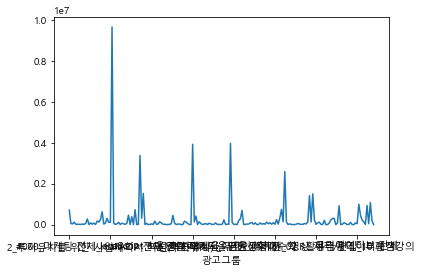

In [91]:
#노출수 칼럼 선그래프
df_group['노출수'].plot()
plt.show()

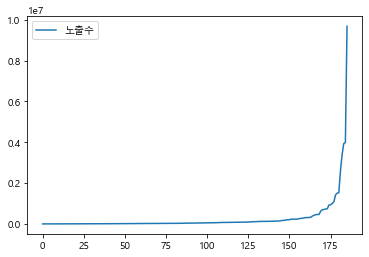

In [93]:
#노출수 칼럼 선그래프
(((df_group['노출수'].sort_values()).reset_index()).drop('광고그룹',axis=1)).plot()
plt.show()

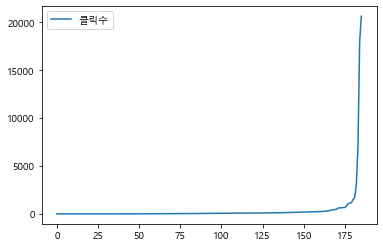

In [94]:
#클릭수 칼럼 선그래프
(((df_group['클릭수'].sort_values()).reset_index()).drop('광고그룹',axis=1)).plot()
plt.show()

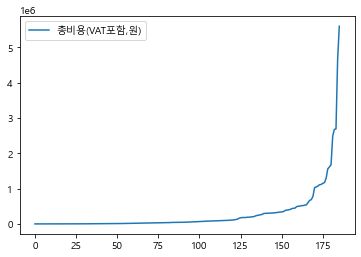

In [95]:
#총비용 칼럼 선그래프
(((df_group['총비용(VAT포함,원)'].sort_values()).reset_index()).drop('광고그룹',axis=1)).plot()
plt.show()

#### 중점관리 광고그룹 / 저효율 광고그룹
- 중점관리 광고그룹
 1. 상위20%(노출수 80백분위수 이상)
 2. 상위10%(클릭수 90백분위수 이상)

In [96]:
imp=df_group['노출수']
clk=df_group['클릭수']

result=df_group[(imp>=imp.quantile(0.8))&(clk>=clk.quantile(0.9))]

result.index

Index(['#000_마케팅 전체_main', '1. 코딩', '3. html', '6. 파이썬', 'AOP 전체_중복키워드_디자인',
       'AOP 전체_중복키워드_비지니스', 'ㅍAOP 전체_중복키워드_디자인(삭제)', '마케팅 전체',
       '올인원 패키지 : 데이터 분석 입문 온라인_파콘', '올인원 패키지 : 디자인 툴_파워컨텐츠_포토샵',
       '올인원 패키지 : 업무자동화_VBA', '타이포그래피와 편집디자인', '프로그래밍 전체_파워컨텐츠_블록체인(삭제)'],
      dtype='object', name='광고그룹')

- 저효율 광고그룹 : 
 노출수, 클릭수  기준 상위의 키워드가 아닌데도 불구하고 비용이 많이 쓰이고 있는 광고그룹
 1. 노출수 80백분위수 미만
 2. 클릭수 90백분위수 미만
 3. 총비용 60백분위수 이상
 4. 총비용 90백분위수 미만

In [97]:
cost=df_group['총비용(VAT포함,원)']

result=df_group[(imp<imp.quantile(0.8))&(clk<clk.quantile(0.9))&(cost>=cost.quantile(0.6))&(cost<cost.quantile(0.9))]

#index - 저효율 광고그룹 출력
result.index

Index(['001.데이터분석/ 통계', '002.마케팅 입문', '003.퍼포먼스 마케팅', '1. 전체', '2. 프로그래밍',
       '5. 자료구조', 'AOP 전체_중복키워드_공통', 'AOP 전체_중복키워드_데이터사이언스',
       'AOP 전체_중복키워드_프로그래밍', 'JavaScript BOOT CAMP',
       'Python & Django를 활용한 웹 서비스_개발자', 'SEO/SEM 전략',
       'TensorFlow로 시작하는 딥러닝 입문', 'fin_camp_auction_6', 'ㅍAOP 전체_중복키워드_공통(삭제)',
       'ㅍAOP 전체_중복키워드_마케팅(삭제)', 'ㅍAOP 전체_중복키워드_프로그래밍(삭제)',
       'ㅍ올인원 패키지 : UX/UI 디자인 입문_연관검색어(삭제)', 'ㅍ올인원 패키지 : 브랜딩',
       '고객의 마음을 읽는 구글애널리틱스', '대기업을 이기는 브랜딩 전략', '마케터를 위한 데이터 부트캠프',
       '마케터를 위한 데이터 해석 실전', '마케팅 유치원', '마케팅KPI수립',
       '올인원 패키지 : 1인 쇼핑몰 시작하기_02.쇼핑몰구축', '올인원 패키지 : 1인 쇼핑몰_00.창업_MO',
       '올인원 패키지 : UX/UI 디자인 입문_연관검색어', '올인원 패키지 : 그로스해킹_5.마케팅 분석',
       '올인원 패키지 : 디지털 마케팅_1. 디지털 마케팅', '올인원 패키지 : 브랜딩',
       '올인원 패키지 : 업무자동화_1. 자동화', '올인원 패키지 : 업무자동화_4. VBA',
       '올인원 패키지 : 영상 제작/편집_9.유튜브/유튜버', '왕초보의 파이썬 웹 프로그래밍 CAMP',
       '코딩으로 여행하는 블록체인 서비스', '페이스북&인스타그램 마케팅 실전', '프로그래밍 유치원'],
      dtype='object', name='광고그룹')